## Simulation of Murdock Jr (1962)

A significant feature of the context maintenance and retrieval (CMR) model is its capacity to account for the relative scale-invariance of serial position effects with respect to list length. @murdock1962serial found that changing list lengths across trials in a free recall experiment impacted neither the shape of observed primacy effects during recall nor on the slope of apparent recency effects, though other features of recall sequences did change, such as the overall retrieval probability for initially encoded items as well as the list-list asymptote. Building on these observations, @polyn2009context found that the CMR model could account for these effects of list length on the shape of the serial position curve in free recall using a single parameter configuration.

Here we investigate whether our prototype- and instance-based implementations of CMR can similarly account for recall performance across different list lengths when fitted to predict the sequences of items recalled in our considered dataset. For these comparisons, we leverage a subset of the original behavioral data reported by @murdock1962serial. In the considered subset, 15 subjects performed 240 trials with study lists each consisting of either 20, 30, or 40 unique words presented sequentially -- 80 trials per list length.

In [1]:
#| code-summary: code -- load dependencies and data
from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.datasets import prepare_murdock1962_data, simulate_data
from compmemlearn.models import Classic_CMR, Instance_CMR
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
import matplotlib.pyplot as plt
from numba.core import types
from numba import njit
import seaborn as sns
from psifr import fr
import pandas as pd
import numpy as np

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data(
    '../../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data(
    '../../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data(
    '../../data/MurdData_clean.mat', 2)

For each model variant and each participant, we found through differential evolution optimization the parameter configuration maximizing the likelihood assigned by the model to each recall sequence in all relevant trials, whether with list length of 20 or 30 or 40. The log-likelihoods of the data corresponding to each participant and model variant are plotted in [Figure @fig-Murd62Fits], with a table providing summary statistics. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting little meaningful difference between variants in their effectiveness predicting recall sequences, even when using a single parameter configuration per participant to account for performance across variable list lengths.

In [4]:
#| output: false
#| code-summary: code -- 1) fit PrototypeCMR participant-by-participant

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

subject_trial_count = 80 # Each subject gets 80 trials/lists a piece.
individual_cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count], 
              murd_trials1[start_index:start_index+subject_trial_count], 
              murd_trials2[start_index:start_index+subject_trial_count]]), 
        List([murd_length0, murd_length1, murd_length2]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    individual_cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=False))
    print(individual_cmr_results[-1].fun)

0 0
4478.741784660521
1 80
5622.7403809334055
2 160
5280.248274572789
3 240
5261.673778402243
4 320
5563.023398740454
5 400
5803.631372347558
6 480
4904.933331245685
7 560
4387.605160129757
8 640
4825.225370136963
9 720
5496.713659101357
10 800
4682.7716238313615
11 880
5242.282869799337
12 960
5968.301984647509
13 1040
6352.108617312197
14 1120
5330.974925872958


In [5]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
#    'feature_sensitivity',
    'context_sensitivity',
    'delay_drift_rate',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

subject_trial_count = 80 # Each subject gets 20 trials/lists a piece.
individual_icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count], 
        murd_trials1[start_index:start_index+subject_trial_count], 
        murd_trials2[start_index:start_index+subject_trial_count]]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_icmr,
    {'choice_sensitivity':1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

    individual_icmr_results.append(differential_evolution(
        cost_function, icmr_bounds, disp=False))
    print(individual_icmr_results[-1].fun)

0 0
4476.478928921198
1 80
5682.110686645887
2 160
5285.2811888062115
3 240
5267.037449331703
4 320
5556.852855787622
5 400
5802.342167958244
6 480
4927.554288058252
7 560
4464.462643346291
8 640
4799.538170089065
9 720
5496.517343443795
10 800
4689.472748430078
11 880
5280.1234211411675
12 960
5947.506642471541
13 1040
6358.6665581212455
14 1120
5396.1491005745975


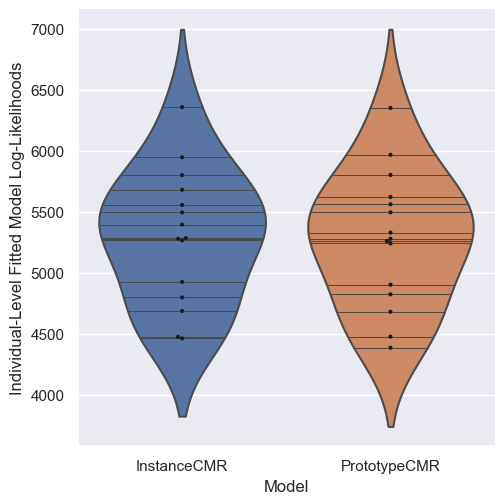

In [26]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects and render summary statistics as table

plt.style.use('default')

individual_fits = [result.fun for result in individual_icmr_results] + [result.fun for result in individual_cmr_results]
labels = ['InstanceCMR'] * len(individual_icmr_results) + ['PrototypeCMR'] * len(individual_cmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_murdock1962.pdf', bbox_inches="tight")
plt.show()

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

In [29]:
#| output: asis
from IPython.display import display, Markdown

display(Markdown("""
::: {{#fig-murd62fits layout-ncol=2 layout-valign="center"}}

![](individual_murdock1962.pdf)

{}

Distribution of log-likelihood scores of recall sequences exhibited by each subject under each considered model across list-lengths [@murdock1962serial]
:::
""".format(summary_table)))


::: {#fig-murd62fits layout-ncol=2 layout-valign="center"}

![](individual_murdock1962.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |         15    |         15     |
| mean  |       5295.34 |       5280.07  |
| std   |        547.19 |        553.484 |
| min   |       4464.46 |       4387.61  |
| 25%   |       4863.55 |       4865.08  |
| 50%   |       5285.28 |       5280.25  |
| 75%   |       5619.48 |       5592.88  |
| max   |       6358.67 |       6352.11  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject under each considered model across list-lengths [@murdock1962serial]
:::


Considering log-likelihoods alone though leaves ambiguous whether the influence of list length on serial position and related organizational effects are effectively accounted for by both models. To find out, we again focused scrutiny on the prototype-based and instance-based implementations of CMR. We fit each model based on the likelihood assigned to all recall sequences across the dataset rather than by subject or list length. Summary statistics including recall probability as a function of serial position, probability of first recall as a function of serial position, and conditional recall probability as a function of serial lag from the previously recalled item were computed based on simulation of free recall data using the model variants with their fitted parameters. Separate analyses simulated trials with study list lengths of 20 and of 30 items, with summary statistics tracked separately. [Figure @fig-Murd62Summary] plots the results of these simulations against statistics from corresponding subsets of the behavioral data from [@murdock1962serial], with unique sets of plots for both model variants and list lengths. As with previous analyses, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the considered data to similar extents.

In [8]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0, murd_trials1, murd_trials2]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 144878
differential_evolution step 2: f(x)= 105041
differential_evolution step 3: f(x)= 92353.9
differential_evolution step 4: f(x)= 92353.9
differential_evolution step 5: f(x)= 92353.9
differential_evolution step 6: f(x)= 92353.9
differential_evolution step 7: f(x)= 92353.9
differential_evolution step 8: f(x)= 89454.8
differential_evolution step 9: f(x)= 89454.8
differential_evolution step 10: f(x)= 87434.7
differential_evolution step 11: f(x)= 87434.7
differential_evolution step 12: f(x)= 82841.8
differential_evolution step 13: f(x)= 82841.8
differential_evolution step 14: f(x)= 82841.8
differential_evolution step 15: f(x)= 82841.8
differential_evolution step 16: f(x)= 82841.8
differential_evolution step 17: f(x)= 82841.8
differential_evolution step 18: f(x)= 82614.4
differential_evolution step 19: f(x)= 82572.5
differential_evolution step 20: f(x)= 81062
differential_evolution step 21: f(x)= 81062
differential_evolution step 22: f(x)= 81062
diffe

In [9]:
#| include: false
print(cmr_result)

     fun: 80052.68887354505
     jac: array([  10.6170773 ,   17.17708073,   -2.77505022,   -2.50875019,
       -123.24599022,   17.89885574,   -2.93221094,    0.        ,
        118.13972376,   26.6605639 ,    7.70960473,    7.07950672])
 message: 'Optimization terminated successfully.'
    nfev: 7882
     nit: 36
 success: True
       x: array([5.88304182e-01, 3.76144942e-02, 7.51294302e-01, 2.91680115e-01,
       1.00000000e+00, 1.39633721e-01, 5.62625588e+00, 4.28789782e+01,
       2.40537436e-02, 2.61824232e-01, 5.32941045e+00, 9.34036191e-01])


In [10]:
#| output: false
#| code-summary: code -- 2) fit Instance_CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0, murd_trials1, murd_trials2]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_icmr,
    {'feature_sensitivity': 1, 'choice_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)
print(icmr_result)

differential_evolution step 1: f(x)= 101461
differential_evolution step 2: f(x)= 101461
differential_evolution step 3: f(x)= 100002
differential_evolution step 4: f(x)= 100002
differential_evolution step 5: f(x)= 100002
differential_evolution step 6: f(x)= 100002
differential_evolution step 7: f(x)= 100002
differential_evolution step 8: f(x)= 100002
differential_evolution step 9: f(x)= 99555.9
differential_evolution step 10: f(x)= 99555.9
differential_evolution step 11: f(x)= 99339
differential_evolution step 12: f(x)= 98916.9
differential_evolution step 13: f(x)= 98916.9
differential_evolution step 14: f(x)= 98916.9
differential_evolution step 15: f(x)= 98916.9
differential_evolution step 16: f(x)= 98916.9
differential_evolution step 17: f(x)= 97747.8
differential_evolution step 18: f(x)= 91766.1
differential_evolution step 19: f(x)= 91766.1
differential_evolution step 20: f(x)= 91766.1
differential_evolution step 21: f(x)= 91766.1
differential_evolution step 22: f(x)= 83096.2
differe

In [11]:
#| include: false
print(icmr_result)

     fun: 80234.29639492511
     jac: array([  4.4252374 ,  -0.9618816 ,  -1.99506757,  26.60963219,
       -79.5989759 ,   6.90779416,  -0.47730282,   0.        ,
         1.22672645,   6.93689799,  -4.70026865,   2.84489941])
 message: 'Optimization terminated successfully.'
    nfev: 13603
     nit: 55
 success: True
       x: array([7.25274023e-01, 5.49552946e-03, 7.76637231e-01, 6.81235304e-03,
       1.00000000e+00, 2.88780665e-01, 6.21718894e+00, 2.83467864e+01,
       2.40239395e-02, 2.61909193e-01, 1.63472597e+00, 9.45953503e-01])


In [12]:
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results
#| output: false

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
model1 = Classic_CMR(murd_length1, murd_length1, fitted_parameters)
model2 = Classic_CMR(murd_length2, murd_length2, fitted_parameters)

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

cmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['PrototypeCMR', 'data'])
cmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr1 = cmr_pfr1.query('output <= 1')

cmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['PrototypeCMR', 'data'])
cmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr2 = cmr_pfr2.query('output <= 1')

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[icmr_free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model0 = Instance_CMR(murd_length0, murd_length0, fitted_parameters)
model1 = Instance_CMR(murd_length1, murd_length1, fitted_parameters)
model2 = Instance_CMR(murd_length2, murd_length2, fitted_parameters)

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

icmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['InstanceCMR', 'data'])
icmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr0 = icmr_pfr0.query('output <= 1')

icmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['InstanceCMR', 'data'])
icmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr1 = icmr_pfr1.query('output <= 1')

icmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['InstanceCMR', 'data'])
icmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr2 = icmr_pfr2.query('output <= 1')

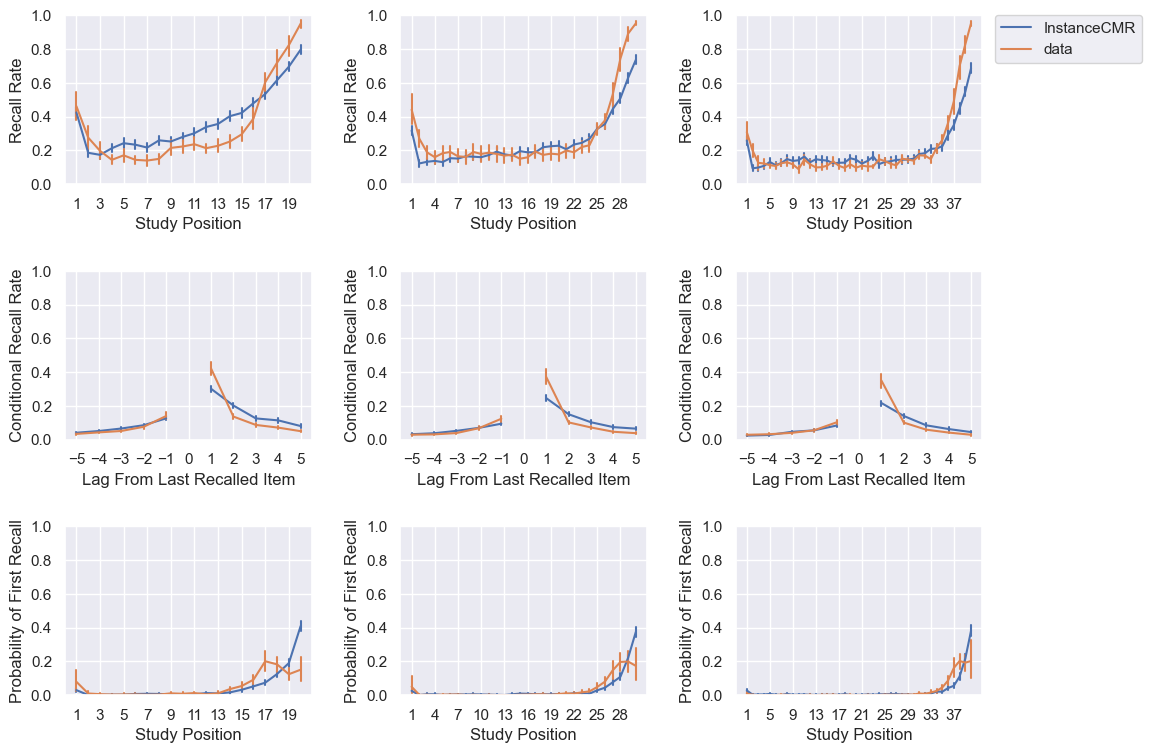

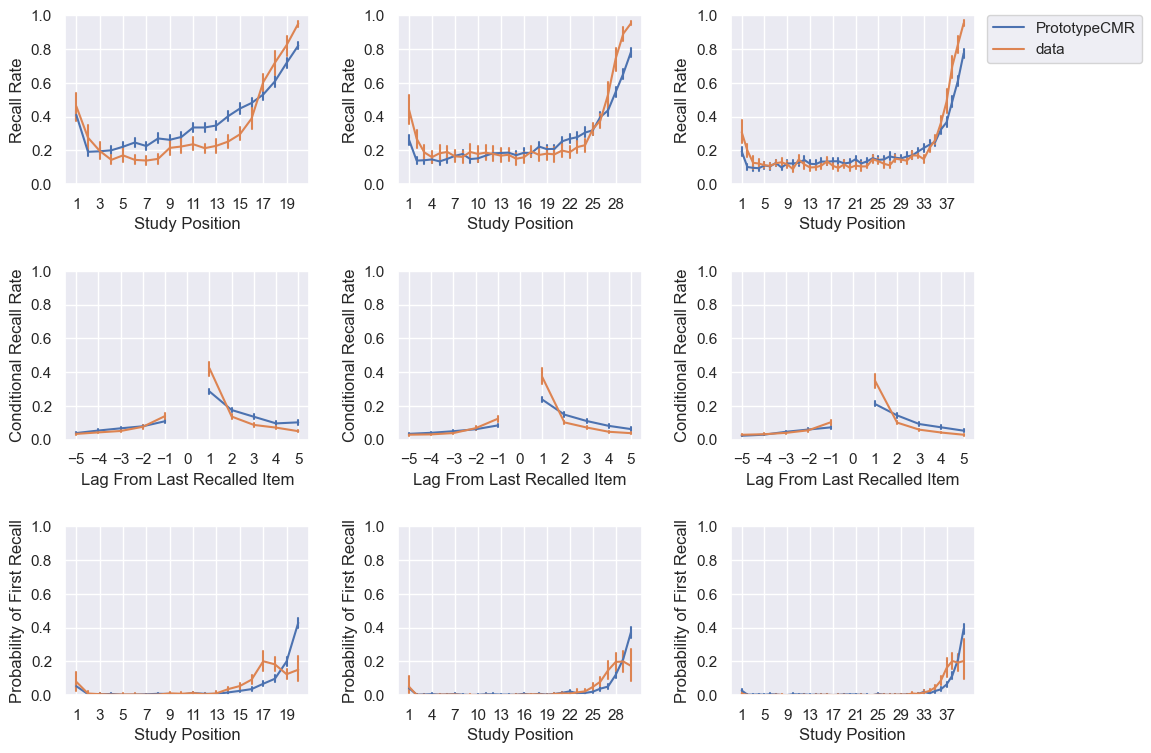

In [13]:
#| code-summary: code -- 4) plot each summary statistic corresponding to InstanceCMR and then PrototypeCMR

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=icmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=icmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('icmr_summary_murdock1962.pdf', bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=cmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=cmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('cmr_summary_murdock1962.pdf', bbox_inches="tight")
plt.show()

::: {#fig-murd62summary layout-nrow=2}

![PrototypeCMR](cmr_summary_murdock1962.pdf){#fig-PrototypeCMR}

![InstanceCMR](icmr_summary_murdock1962.pdf){#fig-InstanceCMR}

Comparison of summary statistics between each model against observed data [@murdock1962serial]
:::